In [4]:
# Upload the Kaggle API token 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexsandrosouza","key":"2b38e9c5ffc40264226eb5108cf2736c"}'}

In [ ]:
# Steps required to download the Kaggle dataset
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download jangedoo/utkface-new  --unzip

# 1. Reading the data

In [2]:
from fastai import *
from fastai.vision import *
from fastai.layers import MSELossFlat, CrossEntropyFlat
from torchvision import transforms
import warnings
warnings.filterwarnings("ignore")

In [3]:
files_train = get_image_files("UTKFace")
files_valid = get_image_files("crop_part1")

In [4]:
len(files_train), len(files_valid)

(23708, 9780)

In [5]:
df_train = pd.DataFrame(files_train,columns=["name"])
df_train.name = df_train.name.apply(str)
df_train["label"] = df_train.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])
df_train["label"] = df_train.label.apply(lambda x: re.sub("_"," ", x))
df_train["age"] = df_train.label.apply(lambda x: int(x.split(" ")[0]))
df_train["gender"] = df_train.label.apply(lambda x: int(x.split(" ")[1]))
df_train["ethnicity"] = df_train.label.apply(lambda x: int(x.split(" ")[2]))

In [6]:
df_valid = pd.DataFrame(files_valid,columns=["name"])
df_valid.name = df_valid.name.apply(str)
df_valid["label"] = df_valid.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])
df_valid["label"] = df_valid.label.apply(lambda x: re.sub("_"," ", x))
df_valid["age"] = df_valid.label.apply(lambda x: int(x.split(" ")[0]))
df_valid["gender"] = df_valid.label.apply(lambda x: int(x.split(" ")[1]))
df_valid["ethnicity"] = df_valid.label.apply(lambda x: int(x.split(" ")[2]))

In [7]:
df_train.head()

name   label  ...  gender  ethnicity
0  UTKFace/26_0_1_20170113181829839.jpg.chip.jpg  26 0 1  ...       0          1
1   UTKFace/1_1_3_20161220220119985.jpg.chip.jpg   1 1 3  ...       1          3
2  UTKFace/54_0_0_20170104212535269.jpg.chip.jpg  54 0 0  ...       0          0
3  UTKFace/37_0_0_20170105172649108.jpg.chip.jpg  37 0 0  ...       0          0
4  UTKFace/25_1_3_20170104222315121.jpg.chip.jpg  25 1 3  ...       1          3

[5 rows x 5 columns]

In [17]:
df_valid.head()

name   label  ...  gender  ethnicity
0   crop_part1/1_1_3_20161220220119985.jpg.chip.jpg   1 1 3  ...       1          3
1  crop_part1/54_0_0_20170104212535269.jpg.chip.jpg  54 0 0  ...       0          0
2  crop_part1/37_0_0_20170105172649108.jpg.chip.jpg  37 0 0  ...       0          0
3  crop_part1/25_1_3_20170104222315121.jpg.chip.jpg  25 1 3  ...       1          3
4  crop_part1/52_0_0_20170111203528972.jpg.chip.jpg  52 0 0  ...       0          0

[5 rows x 5 columns]

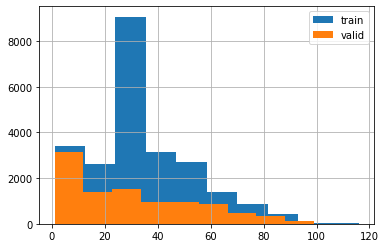

In [18]:
#checking distribution for ages
df_train.age.hist()
df_valid.age.hist()
plt.legend(["train","valid"]);

In [19]:
#should be only 0s and 1s
df_train.gender.unique(), df_valid.gender.unique()

(array([0, 1]), array([1, 0, 3]))

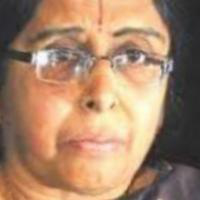

In [20]:
#checking the mislabeled image
open_image(df_valid[df_valid.gender == 3].name.iloc[0])

In [8]:
#fixing the label
idx = df_valid[df_valid.gender == 3].index
df_valid.loc[idx,"gender"] = 1 #1 means woman

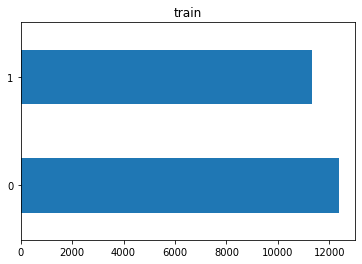

In [9]:
#accuracy is a good metric fore gender
(df_train.gender.value_counts()).plot.barh()
plt.title("train");

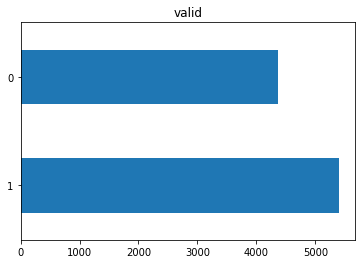

In [10]:
(df_valid.gender.value_counts()).plot.barh()
plt.title("valid");

In [11]:
d = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}
df_train.ethnicity.replace(d).value_counts().sort_index().plot.barh()
plt.title("train");

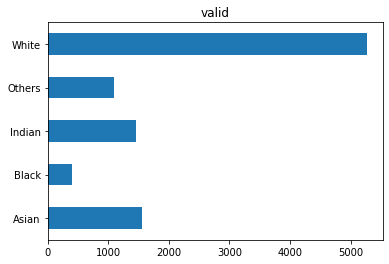

In [12]:
df_valid.ethnicity.replace(d).value_counts().sort_index().plot.barh()
plt.title("valid");

# 2. Creating the Datasets, Dataloaders and Databunch

In [13]:
class MultiTaskDataset(Dataset):
    def __init__(self,df, tfms, size=64):
        self.paths = list(df.name)
        self.labels = list(df.label)
        self.tfms = tfms
        self.size = size
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats

    def __len__(self): return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = PIL.Image.open(self.paths[idx]).convert('RGB')
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        img = img.apply_tfms(self.tfms, size = self.size)
        img = self.norm(img.data)

        #dealing with the labels
        labels = self.labels[idx].split(" ")
        age = torch.tensor(float(labels[0]), dtype=torch.float32)
        gender = torch.tensor(int(labels[1]), dtype=torch.int64)
        ethnicity = torch.tensor(int(labels[2]), dtype=torch.int64)
        
        return img.data, (age.log_()/4.75, gender, ethnicity)

    def show(self,idx):
        x,y = self.__getitem__(idx)
        age,gender,ethnicity = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0)) * stds + means) * 255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {} {}".format(int(age.mul_(4.75).exp_().item()), gender.item(), ethnicity.item()))

In [14]:
tfms = get_transforms()
train_ds = MultiTaskDataset(df_train, tfms[0], size=64)
valid_ds = MultiTaskDataset(df_valid, tfms[1], size=64)
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True, num_workers=2)
data = DataBunch(train_dl, valid_dl)

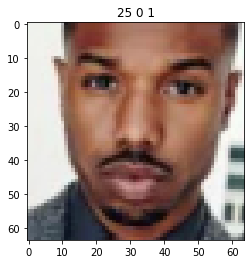

In [15]:
train_ds.show(0)

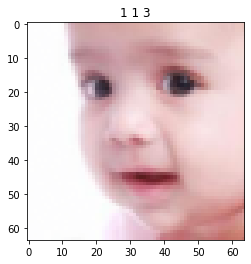

In [35]:
valid_ds.show(0)

In [16]:
class MultiTaskModel(nn.Module):
    def __init__(self, arch, ps=0.5):
        super(MultiTaskModel, self).__init__()
        self.encoder = create_body(arch)
        self.fc1 = create_head(1024,1,ps=ps)
        self.fc2 = create_head(1024,2,ps=ps)
        self.fc3 = create_head(1024,5,ps=ps)

    def forward(self,x):
        x = self.encoder(x)
        age = torch.sigmoid(self.fc1(x))
        gender = self.fc2(x)
        ethnicity = self.fc3(x)

        return [age, gender, ethnicity]

In [17]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskLossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, preds, age, gender, ethnicity):
        mse, crossEntropy = MSELossFlat(), CrossEntropyFlat()
        
        sages = (age*4.75).exp_()
        idx1 = (sages <20) | ((sages > 40) & (sages <= 60))
        idx2 = sages > 60
        loss0 = mse(preds[0], age) + 2*mse(preds[0][idx1],age[idx1]) + 3*mse(preds[0][idx2],age[idx2]) #trying to account for the imbalance
        loss1 = crossEntropy(preds[1],gender)
        loss2 = crossEntropy(preds[2],ethnicity)

        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0*loss0 + self.log_vars[0]

        precision1 = torch.exp(-self.log_vars[1])
        loss1 = precision1*loss1 + self.log_vars[1]

        precision2 = torch.exp(-self.log_vars[2])
        loss2 = precision2*loss2 + self.log_vars[2]
        
        return loss0+loss1+loss2

# 4. Defining Metrics, Learner and Training

In [18]:
def rmse_age(preds, age, gender, ethnicity): return root_mean_squared_error(preds[0],age)
def acc_gender(preds, age, gender, ethnicity): return accuracy(preds[1], gender)
def acc_ethnicity(preds, age, gender, ethnicity): return accuracy(preds[2], ethnicity)
metrics = [rmse_age, acc_gender, acc_ethnicity]

In [19]:
model = MultiTaskModel(models.resnet34, ps=0.25)

loss_func = MultiTaskLossWrapper(3).to(data.device) #just making sure the loss is on the gpu

learn = Learner(data, model, loss_func=loss_func, callback_fns=ShowGraph, metrics=metrics)

#spliting the model so that I can use discriminative learning rates
learn.split([learn.model.encoder[:6],
             learn.model.encoder[6:],
             nn.ModuleList([learn.model.fc1, learn.model.fc2, learn.model.fc3])]);

#first I'll train only the last layer group (the heads)
learn.freeze()

In [20]:
learn.fit_one_cycle(
    15,
    max_lr=1e-2,
    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')]
)

RuntimeError: ignored

In [ ]:
learn.load("stage-1");

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


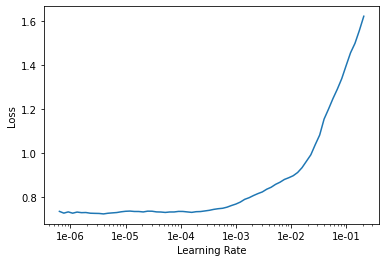

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

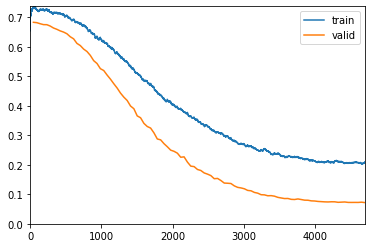

Better model found at epoch 0 with valid_loss value: 0.6835767030715942.
Better model found at epoch 1 with valid_loss value: 0.6823711395263672.
Better model found at epoch 2 with valid_loss value: 0.6788195371627808.
Better model found at epoch 3 with valid_loss value: 0.6757219433784485.
Better model found at epoch 4 with valid_loss value: 0.6754902005195618.
Better model found at epoch 5 with valid_loss value: 0.6709514856338501.
Better model found at epoch 6 with valid_loss value: 0.6642066240310669.
Better model found at epoch 7 with valid_loss value: 0.6598374247550964.
Better model found at epoch 8 with valid_loss value: 0.654427707195282.
Better model found at epoch 9 with valid_loss value: 0.6504475474357605.
Better model found at epoch 10 with valid_loss value: 0.6447869539260864.
Better model found at epoch 11 with valid_loss value: 0.6346135139465332.
Better model found at epoch 12 with valid_loss value: 0.6275506019592285.
Better model found at epoch 13 with valid_loss va

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    100,
    max_lr=slice(1e-6,3e-4),
    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-2')]
)

In [ ]:
learn = learn.load("stage-2")


# 5. Using the model to inference

In [ ]:
trained_model = learn.model.cpu()
torch.save(trained_model.state_dict(),"model_params_resnet34")

In [ ]:
class AgenethPredictor():
    def __init__(self, model):
        self.model = model
        self.tfms = get_transforms()[1]
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats
        self.gender = {0:"Male",1:"Female"}
        self.ethnicity = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

    def predict(self,x):
        #x is a PIL Image
        x = Image(pil2tensor(x, dtype=np.float32).div_(255))
        x = x.apply_tfms(self.tfms, size = 64)
        x = self.norm(x.data)
        preds = self.model(x.unsqueeze(0))
        age = int(torch.exp(preds[0]*4.75).item())
        gender = self.gender[torch.softmax(preds[1],1).argmax().item()]
        ethnicity = self.ethnicity[torch.softmax(preds[2],1).argmax().item()]
        return age, gender, ethnicity

In [ ]:
ageneth_predictor = AgenethPredictor(trained_model)

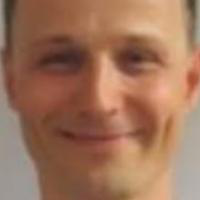

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[100])
img

In [ ]:
df_valid.name.iloc[100]

'utkface_aligned_cropped/crop_part1/37_0_0_20170104205628245.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 54.6 ms, sys: 10.9 ms, total: 65.5 ms
Wall time: 156 ms


(45, 'Male', 'White')

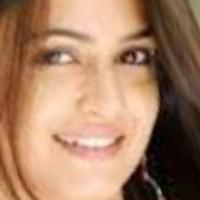

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[1000])
img

In [ ]:
df_valid.name.iloc[1000]

'utkface_aligned_cropped/crop_part1/23_1_3_20170104223058543.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 50.7 ms, sys: 0 ns, total: 50.7 ms
Wall time: 55.5 ms


(23, 'Female', 'Indian')

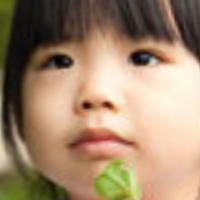

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[2000])
img

In [ ]:
df_valid.name.iloc[2000]

'utkface_aligned_cropped/crop_part1/4_1_2_20161219163346526.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 42 ms, sys: 0 ns, total: 42 ms
Wall time: 43.4 ms


(3, 'Female', 'Asian')

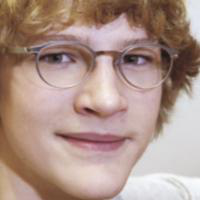

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[50])
img

In [ ]:
df_valid.name.iloc[50]

'utkface_aligned_cropped/crop_part1/16_0_0_20170110232111509.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 43 ms, sys: 0 ns, total: 43 ms
Wall time: 43.5 ms


(18, 'Male', 'White')

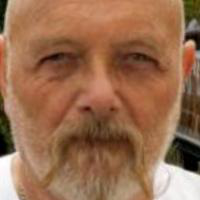

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[9000])
img

In [ ]:
df_valid.name.iloc[9000]

'utkface_aligned_cropped/crop_part1/65_0_0_20170111200004259.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 41.3 ms, sys: 692 µs, total: 41.9 ms
Wall time: 44.7 ms


(64, 'Male', 'White')

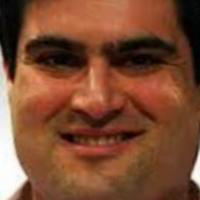

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[-1])
img

In [ ]:
df_valid.name.iloc[-1]

'utkface_aligned_cropped/crop_part1/34_0_4_20170105165000683.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 53.5 ms, sys: 2.43 ms, total: 55.9 ms
Wall time: 59.2 ms


(38, 'Male', 'Others')

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[-100])
img

In [ ]:
df_valid.name.iloc[-100]

'utkface_aligned_cropped/crop_part1/53_1_0_20170110144754148.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 43.3 ms, sys: 1.74 ms, total: 45 ms
Wall time: 45.3 ms


(25, 'Female', 'White')

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[-500])
img

In [ ]:
df_valid.name.iloc[-500]

'utkface_aligned_cropped/crop_part1/26_1_0_20170103180946896.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 40.6 ms, sys: 309 µs, total: 40.9 ms
Wall time: 45.1 ms


(47, 'Female', 'White')